In [1]:
import pickle
import networkx as nx
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

In [2]:
# plt.style.use('seaborn-v0_8-white')
sns.set_style("whitegrid")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [44]:
def community_and_core(G, filename=None, seed=9):
    opt_coms = nx.community.louvain_communities(G, seed=seed)
    opt_mod = nx.community.modularity(G, opt_coms)
    dQ = pd.DataFrame()
    for i in range(len(opt_coms)):
        opt_c = opt_coms.copy()
        com = list(opt_c.pop(i))
        oth_coms = opt_c
        for j in tqdm(range(len(com))):
            elem = com.pop(j)
            mods = []
            for k in range(len(oth_coms)):
                oth_com = oth_coms[k]
                oth_com.add(elem)
                mod = nx.community.modularity(G, [set(com), *oth_coms])
                mods.append(mod - opt_mod)
                oth_com.remove(elem)
            df = pd.DataFrame({'node_id': elem, 'party': G.nodes(data='party')[elem], 'community': i, 'min_dQ': [np.min(mods)], 'max_dQ': [np.max(mods)]})
            dQ = pd.concat([dQ, df], ignore_index=True) 
            com.insert(k, elem)
    dQ['min_dQ'] = dQ['min_dQ'].abs() * 10000
    dQ['max_dQ'] = dQ['max_dQ'].abs() * 10000
    if filename:
        dQ.to_csv(filename, index=False)
    return dQ
    

# 3rd term

In [45]:
k = '3'
save_to_file = f"dQ/dQ_{k}.csv"
save_to_file_mon = f"dQ/monthly/dQ_{k}.csv"

In [46]:
G = pickle.load(open(f'graphs/G_{k}.pickle', 'rb'))
unique_parties = list(set(dict(G.nodes(data='party')).values()))
unique_parties # unique party in the whole tenure

['PiS',
 'UW',
 'AWS',
 'PP',
 'Alternatyw',
 'ROP',
 'SLD',
 'PSL',
 'KdP',
 'KPN-OP',
 'ROP-PC',
 'niez.',
 'SKL']

In [47]:
df_dQ = community_and_core(G, save_to_file)

100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:16<00:00, 11.54it/s]


In [48]:
df_dQ = df_dQ.replace('Alternatyw', 'ARS')

In [53]:
df_dQ

,node_id,party,community,min_dQ,max_dQ
0,0,AWS,0,5.203942,5.203942
1,1,KPN-OP,0,3.667501,3.667501
2,4,AWS,0,6.667857,6.667857
3,5,AWS,0,6.639529,6.639529
4,6,SKL,0,5.637174,5.637174
...,...,...,...,...,...
455,449,SLD,1,5.612366,5.612366
456,450,SLD,1,7.756188,7.756188
457,454,PSL,1,2.206047,2.206047
458,456,SLD,1,4.987781,4.987781


In [56]:
df_dQ.groupby('community').size()

community
0    268
1    192
dtype: int64

In [57]:
df_dQ.groupby(['community', 'party']).size()

community  party 
0          ARS         4
           AWS       133
           KPN-OP      1
           KdP         1
           PP          6
           PiS        18
           ROP         1
           ROP-PC      2
           SKL        18
           UW         47
           niez.      37
1          KdP         1
           PSL        26
           SLD       159
           niez.       6
dtype: int64

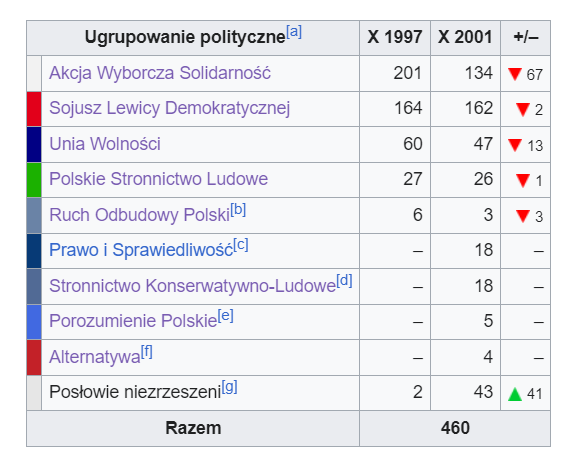

## Stacked histogram of dQ for government and opposition

### All clubs

In [58]:
gov = ['AWS', 'UW']  # UW wyszła z koalicji z AWS, ale przez większość kadencji była w koalicji rządzącej
opp = list(set(unique_parties).difference(set(gov)))

Text(0.5, 1.0, 'Opposition')

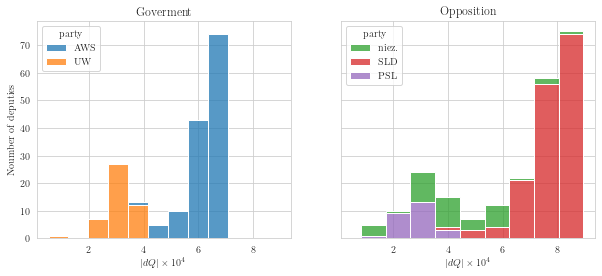

In [62]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
palette = itertools.cycle(sns.color_palette())

sns.histplot(data=df_dQ[df_dQ['party'].isin(gov)], x='min_dQ', hue='party', multiple='stack', ax=ax[0], palette=palette)
ax[0].set_xlabel(r'$|dQ| \times 10^4$')
ax[0].set_ylabel('Number of deputies')
ax[0].set_title('Goverment')


sns.histplot(data=df_dQ[df_dQ['party'].isin(opp)], x='min_dQ', hue='party', multiple='stack', ax=ax[1], palette=palette)
ax[1].set_xlabel(r'$|dQ| \times 10^4$')
ax[1].set_ylabel('Number of deputies')
ax[1].set_title('Opposition')

### Only the biggest clubs

In [60]:
opp = ['SLD', 'PSL', 'niez.']

Text(0.5, 1.0, 'Opposition')

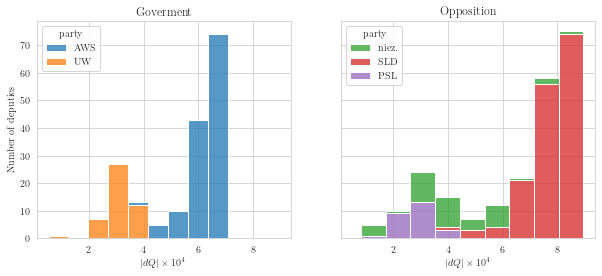

In [63]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
palette = itertools.cycle(sns.color_palette())

sns.histplot(data=df_dQ[df_dQ['party'].isin(gov)], x='min_dQ', hue='party', multiple='stack', ax=ax[0], palette=palette)
ax[0].set_xlabel(r'$|dQ| \times 10^4$')
ax[0].set_ylabel('Number of deputies')
ax[0].set_title('Goverment')


sns.histplot(data=df_dQ[df_dQ['party'].isin(opp)], x='min_dQ', hue='party', multiple='stack', ax=ax[1], palette=palette)
ax[1].set_xlabel(r'$|dQ| \times 10^4$')
ax[1].set_ylabel('Number of deputies')
ax[1].set_title('Opposition')

Text(0.5, 1.0, 'Opposition (2nd community)')

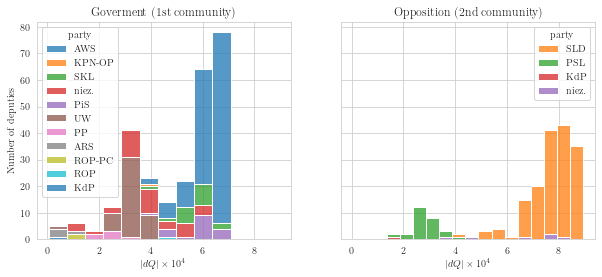

In [73]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
palette = itertools.cycle(sns.color_palette())

sns.histplot(data=df_dQ[df_dQ['community'] == 0], x='min_dQ', hue='party', multiple='stack', ax=ax[0], palette=palette)
ax[0].set_xlabel(r'$|dQ| \times 10^4$')
ax[0].set_ylabel('Number of deputies')
ax[0].set_title('Goverment (1st community)')


sns.histplot(data=df_dQ[df_dQ['community'] == 1], x='min_dQ', hue='party', multiple='stack', ax=ax[1], palette=palette)
ax[1].set_xlabel(r'$|dQ| \times 10^4$')
ax[1].set_ylabel('Number of deputies')
ax[1].set_title('Opposition (2nd community)')

## dQ based on party affilliation

In [64]:
unique_parties

['PiS',
 'UW',
 'AWS',
 'PP',
 'Alternatyw',
 'ROP',
 'SLD',
 'PSL',
 'KdP',
 'KPN-OP',
 'ROP-PC',
 'niez.',
 'SKL']

In [68]:
len(unique_parties)

13

In [65]:
coms = []
for party in unique_parties:
    nodes_party = []
    for node_id, node_party in dict(G.nodes(data='party')).items():
        if party == node_party:
            nodes_party.append(node_id)
    coms.append(set(nodes_party))

In [67]:
len(coms)

13

In [69]:
def party_and_coreness(G):
    unique_parties = list(set(dict(G.nodes(data='party')).values()))
    
    coms = []
    for party in unique_parties:
        nodes_party = []
        for node_id, node_party in dict(G.nodes(data='party')).items():
            if party == node_party:
                nodes_party.append(node_id)
        coms.append(set(nodes_party))
    
    opt_coms = coms
    opt_mod = nx.community.modularity(G, opt_coms)
    dQ = pd.DataFrame()
    for i in range(len(opt_coms)):
        opt_c = opt_coms.copy()
        com = list(opt_c.pop(i))
        oth_coms = opt_c
        for j in tqdm(range(len(com))):
            elem = com.pop(j)
            mods = []
            for k in range(len(oth_coms)):
                oth_com = oth_coms[k]
                oth_com.add(elem)
                mod = nx.community.modularity(G, [set(com), *oth_coms])
                mods.append(mod - opt_mod)
                oth_com.remove(elem)
            df = pd.DataFrame({'node_id': elem, 'party': G.nodes(data='party')[elem], 'community': i, 'min_dQ': [np.min(mods)], 'max_dQ': [np.max(mods)]})
            dQ = pd.concat([dQ, df], ignore_index=True) 
            com.insert(k, elem)
    return dQ

In [70]:
dQ_party = party_and_coreness(G)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:21<00:00,  1.19s/it]


In [74]:
dQ_party['min_dQ'] =  - dQ_party['min_dQ'] * 10000
dQ_party['max_dQ'] =  - dQ_party['max_dQ'] * 10000

#### min -> minimum variation in modularity, i.e. modularity was compared against a setup in which each node was moved, one per time, to its closest community

Text(0.5, 1.0, 'Opposition')

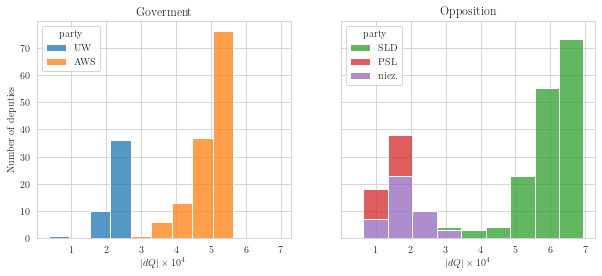

In [75]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
palette = itertools.cycle(sns.color_palette())

sns.histplot(data=dQ_party[dQ_party['party'].isin(gov)], x='min_dQ', hue='party', multiple='stack', ax=ax[0], palette=palette)
ax[0].set_xlabel(r'$|dQ| \times 10^4$')
ax[0].set_ylabel('Number of deputies')
ax[0].set_title('Goverment')


sns.histplot(data=dQ_party[dQ_party['party'].isin(opp)], x='min_dQ', hue='party', multiple='stack', ax=ax[1], palette=palette)
ax[1].set_xlabel(r'$|dQ| \times 10^4$')
ax[1].set_ylabel('Number of deputies')
ax[1].set_title('Opposition')

#### max -> farthest community

Text(0.5, 1.0, 'Opposition')

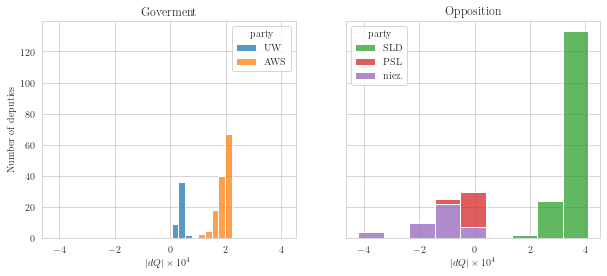

In [76]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
palette = itertools.cycle(sns.color_palette())

sns.histplot(data=dQ_party[dQ_party['party'].isin(gov)], x='max_dQ', hue='party', multiple='stack', ax=ax[0], palette=palette)
ax[0].set_xlabel(r'$|dQ| \times 10^4$')
ax[0].set_ylabel('Number of deputies')
ax[0].set_title('Goverment')


sns.histplot(data=dQ_party[dQ_party['party'].isin(opp)], x='max_dQ', hue='party', multiple='stack', ax=ax[1], palette=palette)
ax[1].set_xlabel(r'$|dQ| \times 10^4$')
ax[1].set_ylabel('Number of deputies')
ax[1].set_title('Opposition')

In [78]:
dQ_party

,node_id,party,community,min_dQ,max_dQ
0,228,PiS,0,3.288688,-1.917821
1,73,PiS,0,2.235626,-1.240781
2,360,PiS,0,3.081429,-1.741725
3,174,PiS,0,2.871481,-1.715215
4,145,PiS,0,2.273899,-1.331690
...,...,...,...,...,...
455,318,SKL,12,2.594621,-1.307995
456,226,SKL,12,3.022346,-1.784432
457,239,SKL,12,3.030347,-1.611832
458,112,SKL,12,3.039066,-1.628605
